In [2]:
# Data preparation for Ph.D thesis
# @author: Andres L. Suarez-Cetrulo
%config IPCompleter.greedy=True
%load_ext jupyternotify
%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
import subprocess
# Define this to parse the CSVs to ARFF later automatically
def create_arff_file(filename, output=None):
    java_mem = '-Xmx3074m'
    filename = filename.replace('.csv', '')
    if output is None:
        output=filename
    else:
        output = output.replace('.csv', '')
    wekadev_libpath = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\lib\\weka-dev-3.7.12.jar'
    command = ['java', java_mem, '-classpath', wekadev_libpath,
               'weka.core.converters.CSVLoader', filename + '.csv', '>', output + '.arff']
    f = open(filename + '.arff', "w")
    subprocess.call(command, stdout=f)
    print('If the arff is not generated, run the next in the terminal.')
    print(str(' '.join(command)))

In [36]:
# Imports
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
import os

# Using TALib abstract API to create a dictionary of technical indicators to iterate later.
from talib import abstract

In [37]:
# Creating a dictionary of technical indicators using TALib abstract API
indicators = ['sma','ema','wma','mom','stoch','macd' ,'rsi' ,'willr',
              'adosc' ,'cci','adx','aroon' ,'bbands','obv' ,'trima',
              'roc' ,'rocr','stochf','medprice','typprice','wclprice',
              'atr','macdfix','mfi' ,'sar' ,'ppo']

def get_indicator(ind: str):
    return abstract.Function(ind)

# Add as many indicators as necessary: see all indicators in https://mrjbq7.github.io/ta-lib/

In [68]:
# Paths
# Paths for symbols (not eft)
# DATA_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','output'])
DATA_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','output', 'synthetic3'])

# '/Users/asuarez/Downloads'
SOURCE_PATH=DATA_PATH # +'raw\\alpha_vantage\\S&P500\\symbols\\AAPL\\'  # 'raw/alpha_vantage/'
RESULT_PATH=DATA_PATH # +'analysis\\'+SYMBOL.lower()+'\\'

# List of dates for files to be loaded
# First synthetic set
# filename = 'timeseries_created_1576000391' # 'timeseries_created_1574259300' 'timeseries_created_1574272163'
# Second synthetic set
# filename = 'timeseries_created_1606044962' 
# filename  = 'timeseries_created_1607428151' # plan b synthetic3
filename  = 'timeseries_created_1607572321' # best candidate synthetic 3
FIELD = 'ts' # price->'ts' returns->'ret_ts' ts_with_added_noise-> 'ts_n2_post'

file = os.sep.join([SOURCE_PATH, filename+'.csv'])
RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename+'_indicators.csv'])

In [54]:
file

'C:\\Users\\suare\\PycharmProjects\\RegimeSwitchingSeriesGenerator\\output\\synthetic3\\timeseries_created_1607572321.csv'

<AxesSubplot:>

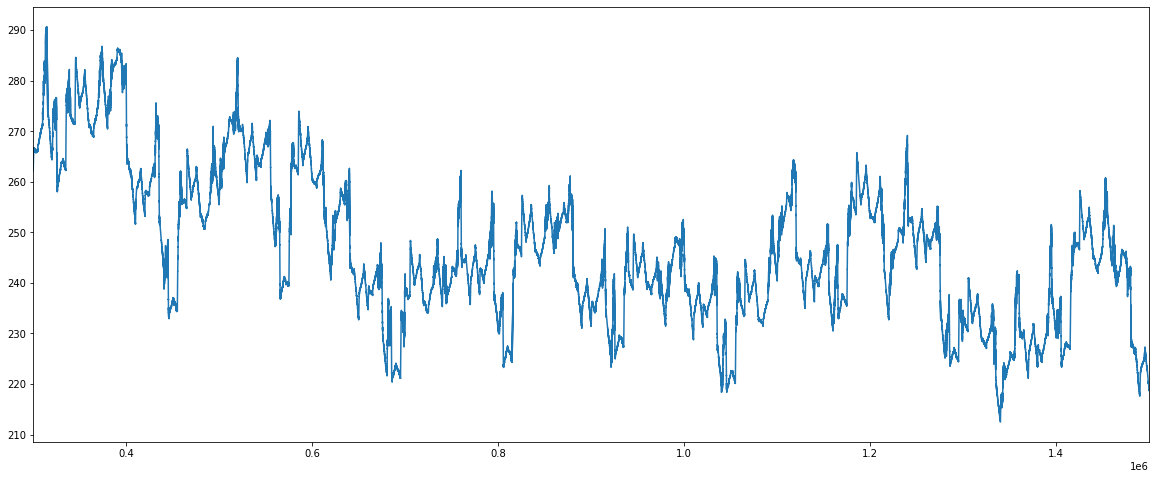

In [55]:
df=pd.read_csv(file)
df.tail(1200000).ts.plot(figsize=(20,8))
# synthetic 3

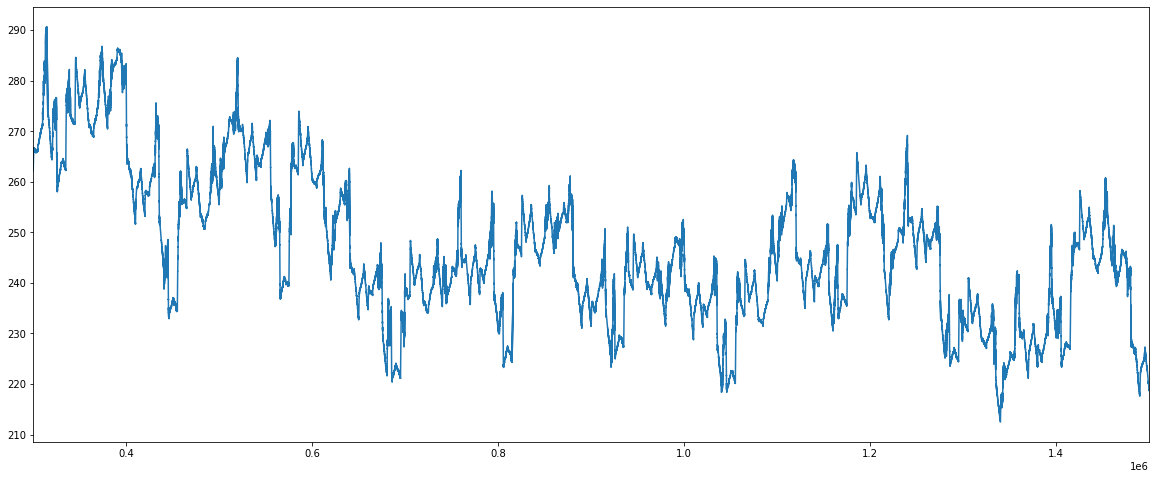

In [69]:
df=pd.read_csv(file)
df.tail(1200000).ts.plot(figsize=(20,8))
plt.savefig(file.split(os.sep)[-1].replace('.csv', '.pdf'))
# plan b

In [56]:
# Open file
df=pd.read_csv(file)
df['close'] = df[FIELD]
df['open'] = df[FIELD].shift(1) # close value of previous period/row
initial_len = len(df)
df.dropna(inplace=True) # remove first row as open is NaN
assert len(df) + 1 == initial_len
df['high'] = pd.np.maximum(df['open'], df['close'])
df['low'] = pd.np.minimum(df['open'], df['close'])
df = df[['open','close','high','low']]
df.head()

,open,close,high,low
1,319.554231,319.500954,319.554231,319.500954
2,319.500954,319.500577,319.500954,319.500577
3,319.500577,319.510620,319.510620,319.500577
4,319.510620,319.489107,319.510620,319.489107
5,319.489107,319.515416,319.515416,319.489107


In [57]:
#Add parameters to transform in TS
timeseries=['close']
#Length of the TS. How many values do we keep per serie. 
# e.g. 1 -> t / 2 -> t,t-1 / 3 -> t,t-1,t-2 / 4 -> t,t-1,t-2,t-3
length = 5

# Add lagged times
for column in timeseries:
    #df[column+'_t']=df[column]
    for i in range(1,length):
        df[column+'_t-'+str(i)]=df[column].shift(i) #it could also be sorted and group by if needed
    #del drops the delected df column
    #del df[column]
df.head()

,open,close,high,low,close_t-1,close_t-2,close_t-3,close_t-4
1,319.554231,319.500954,319.554231,319.500954,NaN,NaN,NaN,NaN
2,319.500954,319.500577,319.500954,319.500577,319.500954,NaN,NaN,NaN
3,319.500577,319.510620,319.510620,319.500577,319.500577,319.500954,NaN,NaN
4,319.510620,319.489107,319.510620,319.489107,319.510620,319.500577,319.500954,NaN
5,319.489107,319.515416,319.515416,319.489107,319.489107,319.510620,319.500577,319.500954


In [58]:
# all the numbers here and below assume a default time period for ta params of 10 mins averages
# change the other numbers (params of 5min and 20min and theremoval of 20 first mins of the day below) if the mins number is changed.
# in that case change as well the time tag '_10' with the corresponding one.
default_timerange=10
# Set extra timeranges for moving averages
extra_timeranges=[default_timerange/2, default_timerange, default_timerange*2, default_timerange*3]

# ###########################################
# Iterate and run list of indicators selected
# All of them produced for 25 prior mins of data 
# ###########################################
for ind in list(indicators):
    if ind not in ['adosc', 'obv', 'mfi']:  # avoiding indicators that need volume
        # For indicators that only return one column (this will need to be modified depending on the selection of indicators)
        if ind in ['ema','sma','trima']:
            for timerange in extra_timeranges:
                df[ind+'_'+str(int(timerange))] = get_indicator(ind)(df, timeperiod=timerange) 
        elif ind not in ['bbands','aroon','stoch','macd','macdfix','stochf']:
            df[ind+'_'+str(int(default_timerange))] = get_indicator(ind)(df, timeperiod=(default_timerange))
        # Otherwise check the list of columns and return all
        else: 
            key_output=get_indicator(ind)(df, timeperiod=(default_timerange)) #, price='close')
            for j in range(0,len(list(key_output.columns))):
                df[ind+'_'+key_output.columns[int(j)]] = key_output[key_output.columns[j]]
df.head()

,open,close,high,low,close_t-1,close_t-2,close_t-3,close_t-4,sma_5,sma_10,...,stochf_fastd,medprice_10,typprice_10,wclprice_10,atr_10,macdfix_macd,macdfix_macdsignal,macdfix_macdhist,sar_10,ppo_10
1,319.554231,319.500954,319.554231,319.500954,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,319.527593,319.518713,319.514273,NaN,NaN,NaN,NaN,NaN,NaN
2,319.500954,319.500577,319.500954,319.500577,319.500954,NaN,NaN,NaN,NaN,NaN,...,NaN,319.500766,319.500703,319.500671,NaN,NaN,NaN,NaN,319.554231,NaN
3,319.500577,319.510620,319.510620,319.500577,319.500577,319.500954,NaN,NaN,NaN,NaN,...,NaN,319.505598,319.507272,319.508109,NaN,NaN,NaN,NaN,319.553158,NaN
4,319.510620,319.489107,319.510620,319.489107,319.510620,319.500577,319.500954,NaN,NaN,NaN,...,NaN,319.499863,319.496278,319.494485,NaN,NaN,NaN,NaN,319.552107,NaN
5,319.489107,319.515416,319.515416,319.489107,319.489107,319.510620,319.500577,319.500954,319.503335,NaN,...,NaN,319.502262,319.506646,319.508839,NaN,NaN,NaN,NaN,319.549587,NaN


In [59]:
def set_label(row):
    if row['close_t+1'] > row['close']: return 1
    else: return 0

# One minute ahead closing price
df['close_t+1']=df['close'].shift(-1)

# Creating label/y to be predicted / independent (predicted) feature 'y' 
df['label'] = df.apply(set_label, axis=1)
# df.drop(columns=['n_row', 'new_switch', 'cur_switch', 'current_model_id', 'new_model_id', 
#                  'weights', 'ts', 'ret_ts', 'ts_n1_pre', 'ts_n2_pre', 'ts_n1_post', 'ts_n2_post'], inplace=True)
# df = df[26000:]
df.dropna(inplace=True)
df.head()

,open,close,high,low,close_t-1,close_t-2,close_t-3,close_t-4,sma_5,sma_10,...,typprice_10,wclprice_10,atr_10,macdfix_macd,macdfix_macdsignal,macdfix_macdhist,sar_10,ppo_10,close_t+1,label
34,319.571935,319.567576,319.571935,319.567576,319.571935,319.539167,319.531619,319.528393,319.547738,319.529633,...,319.569029,319.568666,0.014493,0.008910,0.006461,0.002450,319.499986,-0.001344,319.546497,0
35,319.567576,319.546497,319.567576,319.546497,319.567576,319.571935,319.539167,319.531619,319.551359,319.532937,...,319.553523,319.551767,0.015152,0.008659,0.006900,0.001759,319.501425,-0.001726,319.603696,1
36,319.546497,319.603696,319.603696,319.546497,319.546497,319.567576,319.571935,319.539167,319.565774,319.541907,...,319.584629,319.589396,0.019357,0.012655,0.008051,0.004603,319.502835,-0.001114,319.556245,0
37,319.603696,319.556245,319.603696,319.556245,319.603696,319.546497,319.567576,319.571935,319.569190,319.545773,...,319.572062,319.568108,0.022166,0.012095,0.008860,0.003235,319.506869,-0.000355,319.566754,1
38,319.556245,319.566754,319.566754,319.556245,319.556245,319.603696,319.546497,319.567576,319.568154,319.552254,...,319.563251,319.564127,0.021000,0.012307,0.009549,0.002758,319.510742,0.000947,319.572879,1


In [60]:
# df = df[41200:]


In [61]:
# Select columns for output
# columns_selected=['rsi_10' ,'mom_10','ema_10','ema_20','ema_30',
#                  'sma_10','sma_20','sma_30','wma_10','wma_20','wma_30',
#                  'trima_10','trima_20','trima_30',
#                  'roc_10','rocr_10','ppo_10',
#                  'close','close_t-1','close_t-2','close_t-3','close_t-4',
#                  'label']
# df['label'] = df['binary_label']
fullset = False
if fullset:
    RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_fullset.csv'])
    columns_selected=[# 'datetime',
                     'rsi_10','willr_10','macd_macd' ,'cci_10','mom_10',
                     'stoch_slowk','stoch_slowd',
                     'sma_5','sma_10','sma_20','sma_30',
                     'wma_5','wma_10','wma_20','wma_30',
                     'ema_5','ema_10','ema_20','ema_30',
                     'trima_5','trima_10','trima_20','trima_30',
                     'adx_10','bbands_upperband','bbands_middleband','bbands_lowerband',
                     'roc_10','rocr_10','stochf_fastd','stochf_fastk',
                     'aroon_aroondown','aroon_aroonup','medprice_10','typprice_10','wclprice_10',
                     'atr_10','macdfix_macd','sar_10',
                     'adosc_10', 'obv_10', 'mfi_10', 'ppo_10', ########## commented out previosly
                     'volume','volume_t-1','volume_t-2','volume_t-3','volume_t-4',
                     'close','close_t-1','close_t-2','close_t-3','close_t-4',
                     'high','high_t-1','high_t-2','high_t-3','high_t-4',
                     'open','open_t-1','open_t-2','open_t-3','open_t-4',
                     'low','low_t-1','low_t-2','low_t-3','low_t-4',
                     # 'binary_label',
                     'label'] #,'gap_t+1','close_t+1'] # + ['adosc_10', 'obv_10', 'mfi_10', 'ppo_10']
    
else:  # the ones used with the synthetic set due to the lack of volumes also
    RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_indicators_best.csv'])
    # best pool found through indicators grid search script
    columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd','sma_5','sma_10',
                        'wma_10','ema_10','trima_10','adx_10','bbands_upperband','bbands_lowerband','roc_10',
                        'aroon_aroondown','aroon_aroonup','label']

# Export processed data
output = pd.DataFrame(df, columns=columns_selected)
output.to_csv(RESULT_FILEPATH_PROCESSED, sep=',', encoding='utf-8', index = False)
crypto_path = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\data\\real\\real_crypto\\'
create_arff_file(RESULT_FILEPATH_PROCESSED, output=crypto_path+RESULT_FILEPATH_PROCESSED.split(os.sep)[-1]) # export in ARFF

# Printing classes distributions
print("Class distribution: ")
label_zero=len(df[df['label'] == 0])
label_one=len(df[df['label'] == 1])
#print(label_zero)
#print(label_one)
print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

%notify -m "Parsing is finished"

If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\synthetic3\timeseries_created_1607572321_indicators_best.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\real\real_crypto\timeseries_created_1607572321_indicators_best.arff
Class distribution: 
0 in 0.45386459017377073%
1 in 0.5461354098262293%


<IPython.core.display.Javascript object>

In [62]:
# Select columns for output
# columns_selected=['rsi_10' ,'mom_10','ema_10','ema_20','ema_30',
#                  'sma_10','sma_20','sma_30','wma_10','wma_20','wma_30',
#                  'trima_10','trima_20','trima_30',
#                  'roc_10','rocr_10','ppo_10',
#                  'close','close_t-1','close_t-2','close_t-3','close_t-4',
#                  'label']
# df['label'] = df['binary_label']
fullset = True
if fullset:
    RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_fullset.csv'])
    columns_selected=[# 'datetime',
                     'rsi_10','willr_10','macd_macd' ,'cci_10','mom_10',
                     'stoch_slowk','stoch_slowd',
                     'sma_5','sma_10','sma_20','sma_30',
                     'wma_5','wma_10','wma_20','wma_30',
                     'ema_5','ema_10','ema_20','ema_30',
                     'trima_5','trima_10','trima_20','trima_30',
                     'adx_10','bbands_upperband','bbands_middleband','bbands_lowerband',
                     'roc_10','rocr_10','stochf_fastd','stochf_fastk',
                     'aroon_aroondown','aroon_aroonup','medprice_10','typprice_10','wclprice_10',
                     'atr_10','macdfix_macd','sar_10',
                     'adosc_10', 'obv_10', 'mfi_10', 'ppo_10', ########## commented out previosly
                     'volume','volume_t-1','volume_t-2','volume_t-3','volume_t-4',
                     'close','close_t-1','close_t-2','close_t-3','close_t-4',
                     'high','high_t-1','high_t-2','high_t-3','high_t-4',
                     'open','open_t-1','open_t-2','open_t-3','open_t-4',
                     'low','low_t-1','low_t-2','low_t-3','low_t-4',
                     # 'binary_label',
                     'label'] #,'gap_t+1','close_t+1'] # + ['adosc_10', 'obv_10', 'mfi_10', 'ppo_10']
    
else:  # the ones used with the synthetic set due to the lack of volumes also
    RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_indicators_best.csv'])
    # best pool found through indicators grid search script
    columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd','sma_5','sma_10',
                        'wma_10','ema_10','trima_10','adx_10','bbands_upperband','bbands_lowerband','roc_10',
                        'aroon_aroondown','aroon_aroonup','label']

# Export processed data
output = pd.DataFrame(df, columns=columns_selected)
output.to_csv(RESULT_FILEPATH_PROCESSED, sep=',', encoding='utf-8', index = False)
crypto_path = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\data\\real\\real_crypto\\'
create_arff_file(RESULT_FILEPATH_PROCESSED, output=crypto_path+RESULT_FILEPATH_PROCESSED.split(os.sep)[-1]) # export in ARFF

# Printing classes distributions
print("Class distribution: ")
label_zero=len(df[df['label'] == 0])
label_one=len(df[df['label'] == 1])
#print(label_zero)
#print(label_one)
print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

%notify -m "Parsing is finished"

If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\synthetic3\timeseries_created_1607572321_fullset.csv > C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\data\real\real_crypto\timeseries_created_1607572321_fullset.arff
Class distribution: 
0 in 0.45386459017377073%
1 in 0.5461354098262293%


<IPython.core.display.Javascript object>

In [63]:
output.to_csv(RESULT_FILEPATH_PROCESSED, sep=';', encoding='utf-8', index = False)

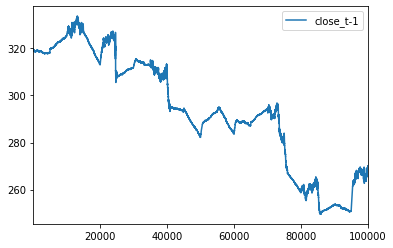

In [64]:
# Now plot close price and volume overtime.
import matplotlib.pyplot as plt
import pandas as pd

df[:100000].plot(y=["close_t-1"])
plt.show()

In [65]:
# Select columns for output
# columns_selected=[
#                  'rsi_10' ,'mom_10','ema_10','ema_20','ema_30',
#                  'sma_10','sma_20','sma_30','wma_10','wma_20','wma_30',
#                  'trima_10','trima_20','trima_30',
#                  'roc_10','rocr_10','ppo_10',
#                  'close','close_t-1','close_t-2','close_t-3','close_t-4',
#                  'label']

# selection through grid search
columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd','sma_5','sma_10',
                    'wma_10','ema_10','trima_10','adx_10','bbands_upperband','bbands_lowerband','roc_10',
                    'aroon_aroondown','aroon_aroonup','label']

# Export processed data
output = pd.DataFrame(df, columns=columns_selected)
# output.to_csv(RESULT_FILEPATH_PROCESSED, sep=';', encoding='utf-8', index = False)

# Printing classes distributions
print("Class distribution: ")
label_zero=len(df[df['label'] == 0])
label_one=len(df[df['label'] == 1])
#print(label_zero)
#print(label_one)
print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

%notify -m "Parsing is finished"

Class distribution: 
0 in 0.45386459017377073%
1 in 0.5461354098262293%


<IPython.core.display.Javascript object>

In [66]:
len(df)

1499965

<AxesSubplot:>

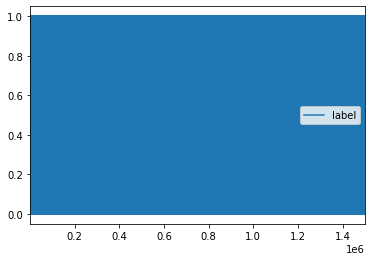

In [67]:
output.plot(y=["label"])
